In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
import re, os, math, sklearn, datetime, pickle
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ratings_df = pd.read_csv('/content/drive/MyDrive/진짜 선택될 데이터/ratings.csv',encoding='utf-8')
movies_df = pd.read_csv('/content/drive/MyDrive/진짜 선택될 데이터/movies.csv',index_col='movieId',encoding='utf-8')
tags_df = pd.read_csv('/content/drive/MyDrive/진짜 선택될 데이터/tags.csv',encoding='utf-8')

In [4]:
print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
print(movies_df.shape)
print(movies_df.head())

(9742, 2)
                                      title  \
movieId                                       
1                          Toy Story (1995)   
2                            Jumanji (1995)   
3                   Grumpier Old Men (1995)   
4                  Waiting to Exhale (1995)   
5        Father of the Bride Part II (1995)   

                                              genres  
movieId                                               
1        Adventure|Animation|Children|Comedy|Fantasy  
2                         Adventure|Children|Fantasy  
3                                     Comedy|Romance  
4                               Comedy|Drama|Romance  
5                                             Comedy  


In [9]:
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB


In [11]:
movies_df.isnull().sum()

title     0
genres    0
dtype: int64

In [12]:
print(tags_df.shape)
print(tags_df.head())

(3683, 4)
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


In [13]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [14]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

몇명이 몇개의 영화에 평점을 줬는지지

In [15]:
num_users = ratings_df['userId'].unique()
num_movies = ratings_df['movieId'].unique()

print("총 유저 수: ", len(num_users))
print("총 영화 수: ", len(num_movies))

총 유저 수:  610
총 영화 수:  9724


이대로 쓰기에는 너무 데이터가 많아 램이 딸려서 안된다. 다른 값으로 대체 해야할 듯

In [16]:
# 유저가 영화에 대해 평점을 준 것을 확인 할 수 있는 matrix 
user_movie_matrix = ratings_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)#만약 유저들이 영화에 평가 하지 않았다면 0으로 채우기
 
# 
sparse_mat = csr_matrix(user_movie_matrix.values)#csr matrix: 희소행렬-> 메모리 낭비가 적음

In [17]:
print(user_movie_matrix)

userId   1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
movieId                                                    ...                  
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  0.0  0.0  0.0  ...  4.0  0.0  4.0   
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  4.0  0.0  0.0  ...  0.0  4.0  0.0   
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
193581   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
193583   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
193585   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
193587   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
193609   0.0  0.0  0.0  0.0 

In [18]:
print(sparse_mat)

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


In [19]:
user_info_df = pd.DataFrame(data = [sum(list(user_movie_matrix[int(x)].value_counts())[1:]) for x in user_movie_matrix.columns],
                           index = user_movie_matrix.columns, columns=['movies_rated'])

# sum(list(user_movie_matrix[1].value_counts())[1:])

In [20]:
user_info_df#한명의 유저가 영화에 대해 얼마만큼의 평점을 줬는지 다 더한 것것

,movies_rated
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [21]:
movie_info_df = pd.DataFrame(data = [sum(list(user_movie_matrix.loc[int(x)].value_counts())[1:]) for x in user_movie_matrix.index],
                           index = user_movie_matrix.index, columns=['users_rated'])

In [22]:
movie_info_df#한 영화에 대해 유저들이 얼마나 점수를 줬는지 알려주는 데이터터

,users_rated
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


# **Movie데이터셋 중 학습셋과 평가셋 나누기**

In [23]:
train_df, val_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [24]:
print(train_df.shape)
print(val_df.shape)

(80668, 4)
(20168, 4)


In [25]:
train_df

,userId,movieId,rating,timestamp
80568,509,7347,3.0,1435994597
50582,326,71462,4.0,1322252335
8344,57,2115,3.0,965798155
99603,610,1127,4.0,1479544102
71701,462,2409,2.0,1174438249
...,...,...,...,...
6265,42,4005,4.0,996259059
54886,364,141,4.0,869443367
76820,480,6867,4.0,1179163171
860,6,981,3.0,845556567


val set에는 존재하지만, train set에는 없는 영화 또는 사용자 비율

In [26]:
# 집합 A - 집합 B => 집합 B에는 없고 집합 A에만 있는 item 

# userId
print("사용자: ",len(list(set(val_df['userId'].unique()) - set(train_df['userId'].unique()))))

# movieId
print("영화: ", len(list(set(val_df['movieId'].unique()) - set(train_df['movieId'].unique()))))
print("val set의 전체 영화 수: ",  len(val_df['movieId'].unique()))

사용자:  0
영화:  741
val set의 전체 영화 수:  5142


In [27]:
movies_not_included = list(set(val_df['movieId'].unique()) - set(train_df['movieId'].unique()))
print(sorted(movies_not_included)[:10])

not_included_df = val_df[val_df.movieId.isin(movies_not_included)].sort_values(by='movieId')
print(not_included_df.head(10))

print("train set에 없고, val set에만 있는 영화 데이터 수: ", not_included_df.shape)

[117, 128, 219, 254, 295, 331, 335, 385, 386, 406]
       userId  movieId  rating   timestamp
97066     604      117     3.0   832080636
37979     260      128     3.0  1109410370
652         6      219     3.0   845556131
669         6      254     3.0   845555655
2323       19      295     3.0   965708038
13148      84      331     3.0   858772206
96185     603      331     3.0   963180195
56186     372      335     4.0   874415062
84140     536      335     3.0   832840487
5070       33      385     4.0   939716559
train set에 없고, val set에만 있는 영화 데이터 수:  (813, 4)


# 랜덤으로 평점 예측하기

In [28]:
# 0.5 - 5.0사이의 숫자를 예측해야할 평점 수 만큼 생성성
ratings_range = np.arange(0.5, 5.5, step=0.5)
ratings_range

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [29]:
import random
pred_random = [random.choice(ratings_range) for x in range(len(val_df))]
pred_random[:10]

[1.5, 1.5, 2.5, 5.0, 5.0, 3.5, 3.5, 3.0, 2.5, 4.0]

In [30]:
val_df['pred_ratings_random'] = pred_random#랜덤으로 val_df의 갯수만큼 생성성

In [31]:
y_true=val_df['rating'].values
y_pred=val_df['pred_ratings_random'].values

In [32]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(mse, rmse)

3.7098621578738595 1.9261002460603809


**영화 평균 평점기반 예측하기**

1.   train set의 모든 영화에 대해서 평균 평점 구하기

2.   test set 예측할 때, train set의 영화 평균 평점 활용하기. 만약 없다면, random으로 선택하기.



In [33]:
train_movie_df = train_df.groupby('movieId').mean()#index가 movieId가 되게 하기

print(train_movie_df.shape)
print(train_movie_df.head())

(8983, 3)
             userId    rating     timestamp
movieId                                    
1        317.741379  3.893678  1.142680e+09
2        329.538462  3.373626  1.145753e+09
3        284.900000  3.162500  1.005732e+09
4        242.500000  2.250000  9.052133e+08
5        329.205882  2.955882  1.006175e+09


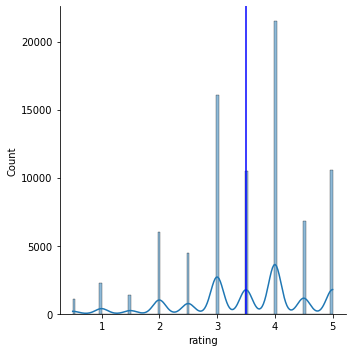

In [34]:
## rain_dfr['rating']의 확률밀도함수를 그려보겠습니다
sns.displot(train_df['rating'], kde=True)

## 평균과, 중앙값으로 수직선을 그려보겠습니다.
plt.axvline(train_df['rating'].mean(), color='blue')

In [35]:
def avg_rating_prediction(training_set, x):##영화 하나의 평균평점을 구하고 만약 없다면 랜덤으로 생성,
    if x in training_set.index:
        pred_rating = training_set.loc[x]['rating']
    else:
        pred_rating = random.choice(ratings_range)
    return pred_rating

In [36]:
val_df['pred_rating_movie'] = val_df['movieId'].apply(lambda x: avg_rating_prediction(train_movie_df, x))

val_df.head()

,userId,movieId,rating,timestamp,pred_ratings_random,pred_rating_movie
67037,432,77866,4.5,1335139641,1.5,2.900000
42175,288,474,3.0,978465565,1.5,3.754386
93850,599,4351,3.0,1498524542,2.5,3.250000
6187,42,2987,4.0,996262677,5.0,3.578947
12229,75,1610,4.0,1158989841,5.0,3.801370


In [37]:
y_true1=val_df['rating'].values
y_pred1=val_df['pred_rating_movie'].values

In [38]:
mse = mean_squared_error(y_true1, y_pred1)
rmse = np.sqrt(mse)

print(mse, rmse)

1.0535238612010944 1.0264131045544451


사용자 평균 평점기반 예측하기


1.   train set의 모든 유저가 준 평균 평점
2.   test set 예측할 때, 유저가 train set에서 준 평균 평점을 활용. 유저가 없을 경우 random 평점 적용




In [39]:
train_user_df = train_df.groupby('userId').mean()

print(train_user_df.shape)
print(train_user_df.head())

(610, 3)
             movieId    rating     timestamp
userId                                      
1        1810.336788  4.331606  9.649824e+08
2       67608.080000  3.920000  1.445715e+09
3        8325.516129  2.580645  1.306464e+09
4        1899.694118  3.464706  9.657212e+08
5         366.842105  3.657895  8.474351e+08


In [40]:
val_df['pred_rating_user'] = val_df['userId'].apply(lambda x: avg_rating_prediction(train_user_df, x))

val_df.head()

,userId,movieId,rating,timestamp,pred_ratings_random,pred_rating_movie,pred_rating_user
67037,432,77866,4.5,1335139641,1.5,2.900000,3.628571
42175,288,474,3.0,978465565,1.5,3.754386,3.131737
93850,599,4351,3.0,1498524542,2.5,3.250000,2.651029
6187,42,2987,4.0,996262677,5.0,3.578947,3.541547
12229,75,1610,4.0,1158989841,5.0,3.801370,3.322034


In [41]:
y_true2=val_df['rating'].values
y_pred2=val_df['pred_rating_user'].values

In [42]:
mse = mean_squared_error(y_true2, y_pred2)
rmse = np.sqrt(mse)

print(mse, rmse)

0.9020188826241128 0.9497467465720074


Rule 기반 영화 평점 예측하기

1.   train set에 포함된 유저의 영화 평균 평점과 영화의 장르를 활용하여, 장르별 평균 평점 계산 -> test set의 영화 장르의 평균 평점으로 예측



In [43]:
# train_df train set을 이용해서 영화별 유저가 평가하는 함수만들기, 결측치는 0으로 채우기(평가를 안해서)
train_user_movie_matrix = train_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [44]:
train_user_movie_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
genres_df = movies_df['genres'].str.get_dummies(sep='|')#장르를 구분분
print(genres_df.shape)

(9742, 20)


In [46]:
genres_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
genres_df = genres_df.loc[train_df.movieId.unique()]#index에 train의 movieId 고유값 넣기
print(genres_df.shape)
genres_df.head()

(8983, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
7347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
71462,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2115,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1127,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2409,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [48]:
# train에서 영화별 유저 평점 평균구하기기
train_movie_avg_ratings_df = train_user_movie_matrix.copy()
train_movie_avg_ratings_df = train_movie_avg_ratings_df.replace(0, np.NaN)#결측치 대체체
train_movie_avg_ratings_df = train_movie_avg_ratings_df.mean(axis = 1)

train_movie_avg_ratings_df.head()

movieId
1    3.893678
2    3.373626
3    3.162500
4    2.250000
5    2.955882
dtype: float64

In [49]:
# genres_df에서 해당 장르가 포함된 모든 영화 index를 가져와서,유저평균을 장르평균을 구할 때때 활용
genres_avg_ratings_df = pd.DataFrame(index=genres_df.columns, columns=['avg_ratings'])

for genre in genres_avg_ratings_df.index:
    genre_avg_rating = train_movie_avg_ratings_df.loc[genres_df[genres_df[genre].isin([1])].index].mean()
    genres_avg_ratings_df.loc[genre]['avg_ratings'] = genre_avg_rating

genres_avg_ratings_df

,avg_ratings
(no genres listed),3.35679
Action,3.121847
Adventure,3.205439
Animation,3.477723
Children,3.115097
Comedy,3.170161
Crime,3.313487
Documentary,3.777727
Drama,3.426015
Fantasy,3.220115


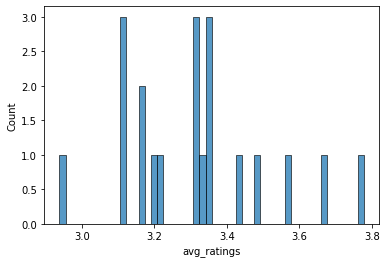

In [50]:
sns.histplot(genres_avg_ratings_df['avg_ratings'], bins=50)

In [51]:
def get_genre_avg_ratings(x):
    genres_list = movies_df.loc[x]['genres'].split('|')
    rating = 0
    for genre in genres_list:
        rating += genres_avg_ratings_df.loc[genre]['avg_ratings']
    
    return rating / len(genres_list)

In [52]:
tqdm.pandas()
val_df['pred_rating_genre'] = val_df['movieId'].progress_apply(lambda x: get_genre_avg_ratings(x))

100%|██████████| 20168/20168 [00:10<00:00, 1911.39it/s]


In [53]:
val_df

,userId,movieId,rating,timestamp,pred_ratings_random,pred_rating_movie,pred_rating_user,pred_rating_genre
67037,432,77866,4.5,1335139641,1.5,2.900000,3.628571,3.335160
42175,288,474,3.0,978465565,1.5,3.754386,3.131737,3.142915
93850,599,4351,3.0,1498524542,2.5,3.250000,2.651029,3.199772
6187,42,2987,4.0,996262677,5.0,3.578947,3.541547,3.262930
12229,75,1610,4.0,1158989841,5.0,3.801370,3.322034,3.163756
...,...,...,...,...,...,...,...,...
57416,380,5048,2.0,1494268065,4.0,2.875000,3.675358,3.163565
67290,434,54272,3.5,1270606860,3.5,3.592105,3.738220,3.323942
33423,226,5989,4.5,1162428551,2.0,3.948454,3.474874,3.369751
98552,607,1320,3.0,963080497,3.5,3.183333,3.744828,3.085319


In [54]:
y_true3=val_df['rating'].values 
y_pred3=val_df['pred_rating_genre'].values

In [55]:
mse = mean_squared_error(y_true3, y_pred3)
rmse = np.sqrt(mse)

print(mse, rmse)

1.1333817433607896 1.0646040312533058


user의 평균 영화 평점을 normalize해서 확인

In [56]:
train_user_info_df = pd.DataFrame({
    'avg_ratings': train_df.groupby('userId')['rating'].mean(),
    'std_ratings': train_df.groupby('userId')['rating'].std(),
    'count_ratings': train_df.groupby('userId')['rating'].count()
})

train_user_info_df

,avg_ratings,std_ratings,count_ratings
userId,,,
1,4.331606,0.812587,193
2,3.920000,0.837655,25
3,2.580645,2.125625,31
4,3.464706,1.372356,170
5,3.657895,1.046908,38
...,...,...,...
606,3.657002,0.706503,914
607,3.744828,0.977378,145
608,3.117820,1.081198,679


In [57]:
min_count = train_user_info_df['count_ratings'].min()
max_count = train_user_info_df['count_ratings'].max()
avg_count = train_user_info_df['count_ratings'].mean()

train_user_info_df['weights'] = train_user_info_df['count_ratings'].apply(lambda x: (x-avg_count)/(max_count-min_count))

In [58]:
train_user_info_df

,avg_ratings,std_ratings,count_ratings,weights
userId,,,,
1,4.331606,0.812587,193,0.028809
2,3.920000,0.837655,25,-0.050850
3,2.580645,2.125625,31,-0.048005
4,3.464706,1.372356,170,0.017903
5,3.657895,1.046908,38,-0.044686
...,...,...,...,...
606,3.657002,0.706503,914,0.370677
607,3.744828,0.977378,145,0.006049
608,3.117820,1.081198,679,0.259250


In [59]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(train_user_info_df)
df_normalized = pd.DataFrame(np_scaled, columns = train_user_info_df.columns, index=train_user_info_df.index)
df_normalized

,avg_ratings,std_ratings,count_ratings,weights
userId,,,,
1,0.817711,0.382282,0.085349,0.085349
2,0.705455,0.394075,0.005690,0.005690
3,0.340176,1.000000,0.008535,0.008535
4,0.581283,0.645625,0.074443,0.074443
5,0.633971,0.492518,0.011854,0.011854
...,...,...,...,...
606,0.633728,0.332374,0.427217,0.427217
607,0.657680,0.459808,0.062589,0.062589
608,0.486678,0.508649,0.315789,0.315789


In [60]:
df_normalized['normalized_avg_ratings'] = df_normalized['avg_ratings'] * 5
df_normalized

,avg_ratings,std_ratings,count_ratings,weights,normalized_avg_ratings
userId,,,,,
1,0.817711,0.382282,0.085349,0.085349,4.088554
2,0.705455,0.394075,0.005690,0.005690,3.527273
3,0.340176,1.000000,0.008535,0.008535,1.700880
4,0.581283,0.645625,0.074443,0.074443,2.906417
5,0.633971,0.492518,0.011854,0.011854,3.169856
...,...,...,...,...,...
606,0.633728,0.332374,0.427217,0.427217,3.168639
607,0.657680,0.459808,0.062589,0.062589,3.288401
608,0.486678,0.508649,0.315789,0.315789,2.433391


In [61]:
val_df['pred_rating_normalized'] = val_df['userId'].apply(lambda x: df_normalized.loc[x]['normalized_avg_ratings'])
val_df

,userId,movieId,rating,timestamp,pred_ratings_random,pred_rating_movie,pred_rating_user,pred_rating_genre,pred_rating_normalized
67037,432,77866,4.5,1335139641,1.5,2.900000,3.628571,3.335160,3.129870
42175,288,474,3.0,978465565,1.5,3.754386,3.131737,3.142915,2.452368
93850,599,4351,3.0,1498524542,2.5,3.250000,2.651029,3.199772,1.796857
6187,42,2987,4.0,996262677,5.0,3.578947,3.541547,3.262930,3.011201
12229,75,1610,4.0,1158989841,5.0,3.801370,3.322034,3.163756,2.711864
...,...,...,...,...,...,...,...,...,...
57416,380,5048,2.0,1494268065,4.0,2.875000,3.675358,3.163565,3.193670
67290,434,54272,3.5,1270606860,3.5,3.592105,3.738220,3.323942,3.279391
33423,226,5989,4.5,1162428551,2.0,3.948454,3.474874,3.369751,2.920283
98552,607,1320,3.0,963080497,3.5,3.183333,3.744828,3.085319,3.288401


In [62]:
y_true4 =val_df['rating'].values
y_pred4 =val_df['pred_rating_normalized'].values

In [63]:
mse = mean_squared_error(y_true4, y_pred4)
rmse = np.sqrt(mse)

print(mse, rmse)

1.2273721504015616 1.1078682910894966
